In [1]:
import cv2

import os
import sys
import numpy as np
import aruco
from matplotlib import pyplot as plt
import torch
sys.path.append('..')
from utils import * # Please note that many of the function used in the notebook are located in the utils

In [2]:
# Constants declaration

# Camera configuration
camera_config = "../arucoConfig/baumer12mm1mf.yml"
camparam = aruco.CameraParameters()
camparam.readFromXMLFile(camera_config)

# Configuration of the boxes and creation of marker maps
lower_box_config = "../arucoConfig/block1(lowest).yml"
higher_box_config = "../arucoConfig/block2(highest).yml"
mmap_lowest = aruco.MarkerMap(lower_box_config)
mmap_highest = aruco.MarkerMap(higher_box_config)

# Example videos
video_example1 = "../Data/baumer_video0043.avi"
video_example2 = "../Data/baumer_video0050.avi"

# Center of the block
lower_box_center_location = "../arucoConfig/AxisCentreBlock1.csv"
upper_box_center_location = "../arucoConfig/AxisCentreBlock2.csv"

lower_box_loc = np.fromstring(open(lower_box_center_location).read(), sep=' ')[-3:]/1000
upper_box_loc = np.fromstring(open(upper_box_center_location).read(), sep=' ')[-3:]/1000

# Direction of the axis
lower_box_rotation = np.fromstring(open(lower_box_center_location).read(), sep=' ')[:3]
upper_box_rotation = np.fromstring(open(upper_box_center_location).read(), sep=' ')[:3]

## How markers are located

detected ids: 7, 15, 19, 21, 24


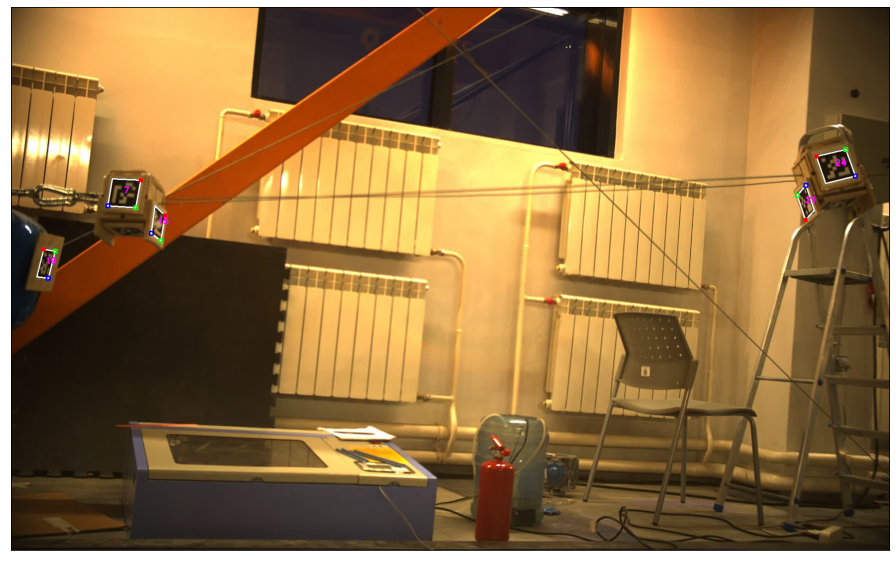

In [3]:
# Open video with cv2
cap = cv2.VideoCapture(video_example1)
ret, frame = cap.read() # Take first frame

# Init detector and get markers
detector = aruco.MarkerDetector()
markers = detector.detect(frame)
print("detected ids: {}".format(", ".join(str(m.id) for m in markers)))

# Draw bounding boxes for all markers
for marker in markers:
    marker.draw(frame, np.array([255, 255, 255]), 2)
    aruco.CvDrawingUtils.draw3dAxis(frame, camparam, marker.Rvec, marker.Tvec, .1)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

## How the markermap location looks like

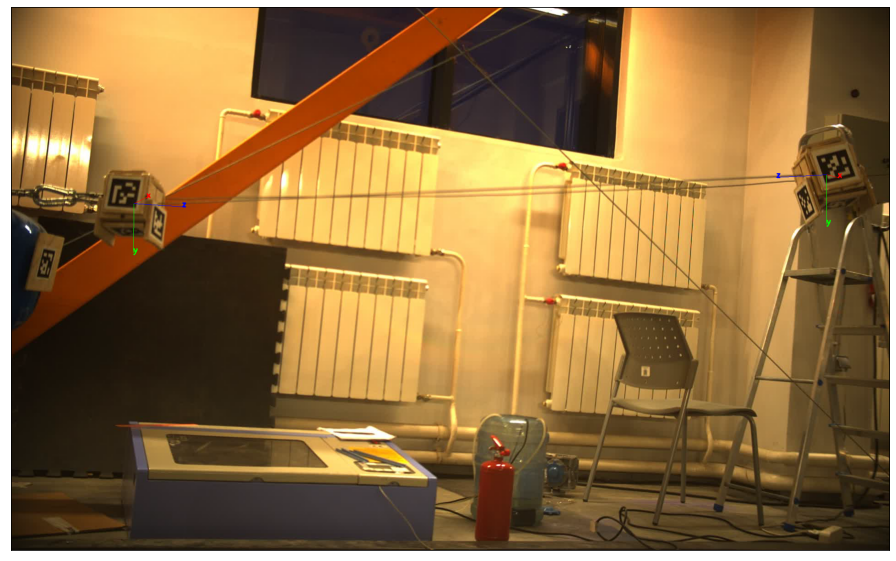

In [4]:
# Take first picture from the video
cap = cv2.VideoCapture(video_example1)
ret, frame = cap.read()

# Init detector and marker map pose trackers
detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)

# We can then detect aruco markers
markers = detector.detect(frame)

# And estimate poses of the marker maps
mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)

# We then draw the axis
aruco.CvDrawingUtils.draw3dAxis(
    frame, camparam, cv2.Rodrigues(lower_box_rotation)[0], # Rotation is converted from Rogrigues form
    np.array([get_center_box_pos(mmap_low_p, lower_box_loc)]), .1) # Center of the box is computed separately

# Same for the second box
aruco.CvDrawingUtils.draw3dAxis(
    frame, camparam, cv2.Rodrigues(upper_box_rotation)[0],
    np.array([get_center_box_pos(mmap_high_p, upper_box_loc)]), .1)


plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
cap = cv2.VideoCapture(video_example2)
ret, frame = cap.read()

# Try to find a picture with at least 4 markers, marker map would fail otherwise (we need at least 2 markers for each box)
while ret:
    detector = aruco.MarkerDetector()
    markers = detector.detect(frame)
    if len(markers) == 4:
        break
    ret, frame = cap.read()

## Check how marker map look in another setting

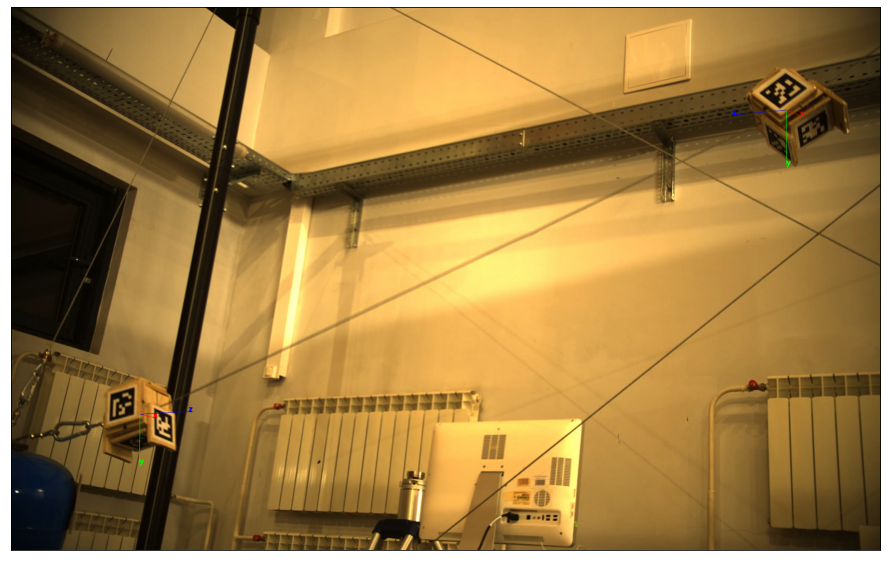

In [6]:
frame_copy = frame.copy()
detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)

markers = detector.detect(frame)
mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)

aruco.CvDrawingUtils.draw3dAxis(
    frame_copy, camparam, cv2.Rodrigues(lower_box_rotation)[0],
    np.array([get_center_box_pos(mmap_low_p, lower_box_loc)]), .1)

aruco.CvDrawingUtils.draw3dAxis(
    frame_copy, camparam, cv2.Rodrigues(upper_box_rotation)[0],
    np.array([get_center_box_pos(mmap_high_p, upper_box_loc)]), .1)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

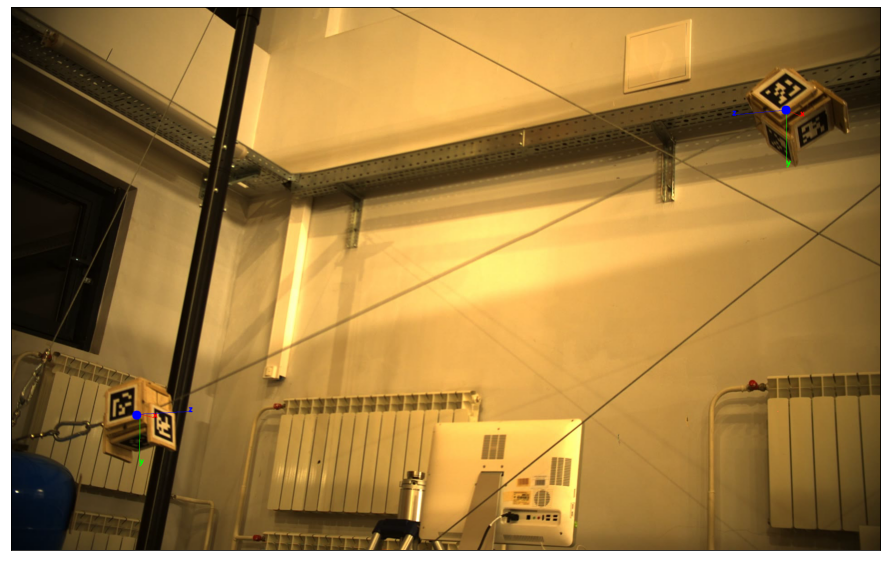

In [7]:
x, y = get_2d_from_3d(get_center_box_pos(mmap_low_p, lower_box_loc), camparam.CameraMatrix)
x2,y2 = get_2d_from_3d(get_center_box_pos(mmap_high_p, upper_box_loc), camparam.CameraMatrix)
img_circles = cv2.circle(frame_copy.copy(),(x,y), 10, [255,0,0], cv2.FILLED)
img_circles = cv2.circle(img_circles, (x2,y2), 10, [255,0,0], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

## Drawing the perfect line

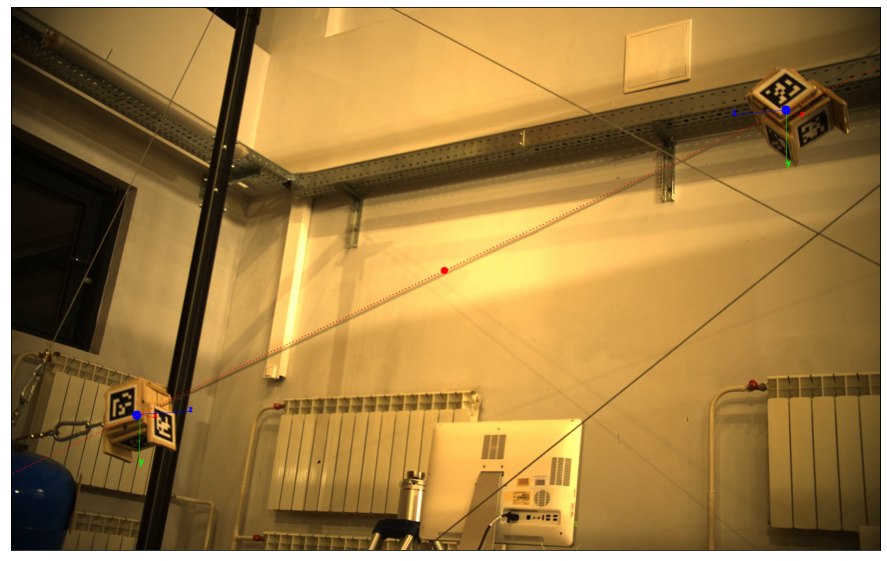

In [8]:
# We can find 3D equation of the line with
# (x,y,z) = B+t*(A-B)
# The middle of the line will be when t=0.5, e.g. 0.5B+0.5A

A = get_center_box_pos(mmap_low_p, lower_box_loc) # 3D position of lower marker map
B = get_center_box_pos(mmap_high_p, upper_box_loc) # 3D position of upper marker map

mp = A*0.5+0.5*B # Middle point

# Draw the middle point
img_circles = cv2.circle(img_circles, get_2d_from_3d(mp, camparam.CameraMatrix), 8, [0,0,255], cv2.FILLED)

# We can draw the rest of the line
f = lambda t: B+t*(A-B)
for i in np.arange(-10, 100, step=0.005):
    res = f(i)
    img_circles = cv2.circle(img_circles, get_2d_from_3d(res, camparam.CameraMatrix), 1, [0,0,255], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

## Locating the wire

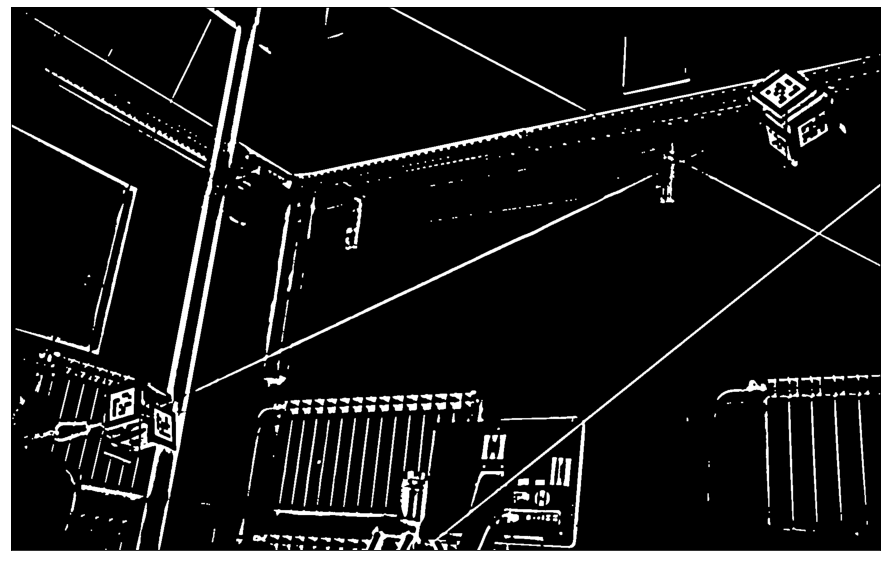

In [9]:
grayed = search_for_line(frame_copy)
plt.figure(figsize=(20,10))
plt.imshow(grayed, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

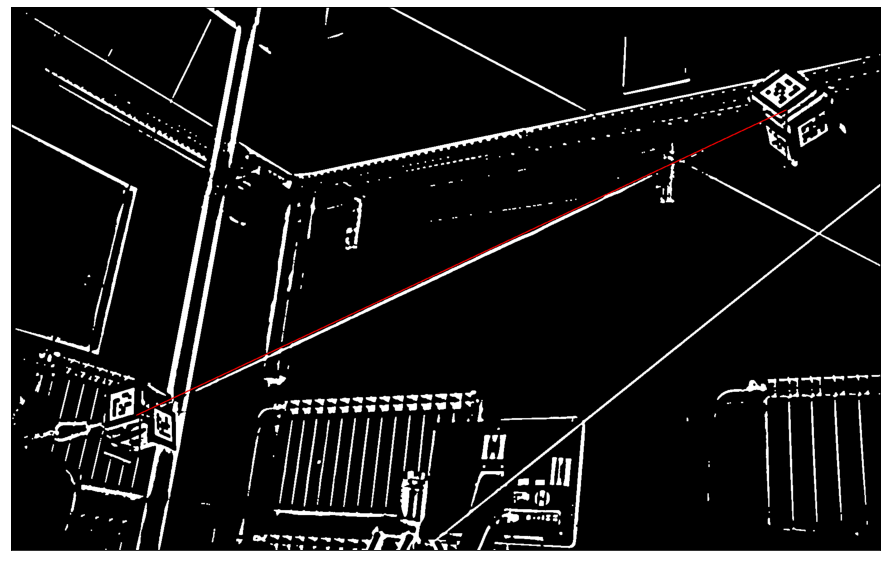

In [10]:
# Red wire represents the perfect location of the cable
line_p1 = get_2d_from_3d(A, camparam.CameraMatrix)
line_p2 = get_2d_from_3d(B, camparam.CameraMatrix)

grayed_with_line = cv2.cvtColor(grayed, cv2.COLOR_GRAY2RGB)
grayed_with_line = cv2.line(grayed_with_line,
                             line_p1,
                             line_p2,
                             [255,0,0], 2)
plt.figure(figsize=(20,10))
plt.imshow(grayed_with_line)
plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
# Find the cable from the 'perfect' line

rays = []
middle_point = int((line_p1[1]+line_p2[1])/2), int((line_p2[0]+line_p1[0])/2) # Middle point of the red line
current_ray = Ray()

# Send a ray down to the bottom of the picture and locate any white pixels in a row
while middle_point[0] != grayed.shape[0]:
    # If white pixel found - add it to the current ray
    if np.all(grayed[middle_point] == [255,255,255]):
        current_ray.add_point(middle_point)
    # else, create a new one if previous one size wasn't 0
    elif current_ray.width != 0:
        rays.append(current_ray)
        current_ray = Ray()
    # Proceed with the iteration
    middle_point = (middle_point[0]+1, middle_point[1]) 

## The distance between our cable and the perfect one

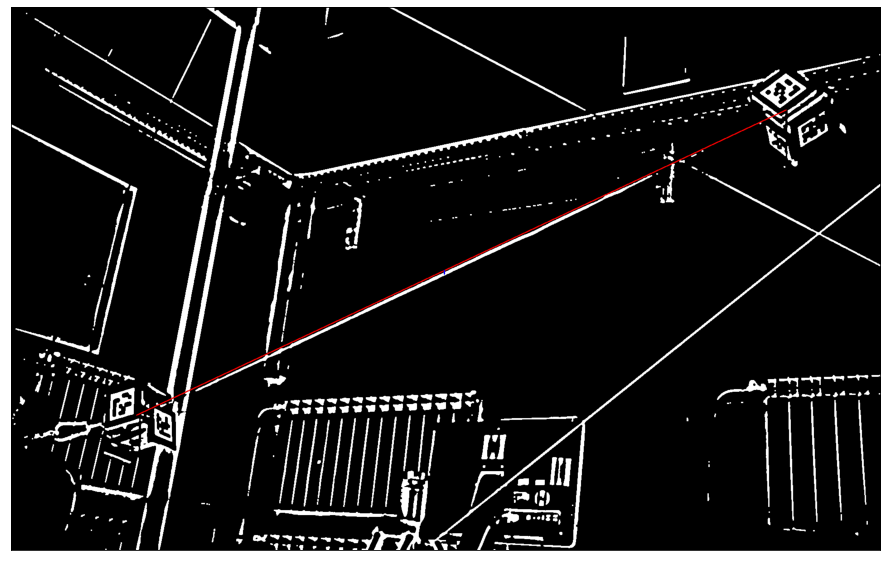

The difference is ~8 pixels to the middle of the cable
Or ~4 pixels from the beginning of the cable
The sagging is ~7.60 mm


In [12]:
new_rays = []
mid_point = get_2d_from_3d(mp, camparam.CameraMatrix)[::-1] # Middle point of the red line
current_ray = Ray()

# Send a ray down to the bottom of the picture and locate any white pixels in a row
while mid_point[0] != grayed.shape[0]:
    # If white pixel found - add it to the current ray
    if np.all(grayed[mid_point] == [255,255,255]):
        current_ray.add_point(mid_point)
    # else, create a new one if previous one size wasn't 0
    elif current_ray.width != 0:
        new_rays.append(current_ray)
        current_ray = Ray()
    # Proceed with the iteration
    mid_point = (mid_point[0]+1, mid_point[1])
    
start = get_2d_from_3d(mp, camparam.CameraMatrix) # starting point
end = new_rays[0].get_middle() # middle of the cable
grayed_new = cv2.line(grayed_with_line.copy(), start, end, [0,0,255], 2)

plt.figure(figsize=(20,10))
plt.imshow(grayed_new)
plt.xticks([]), plt.yticks([])
plt.show()
print(f"The difference is ~{end[1] - start[1]} pixels to the middle of the cable")
print(f"Or ~{new_rays[0].starting_pos[0]-start[1]} pixels from the beginning of the cable")

lp = mp.copy()
while not get_2d_from_3d(lp, camparam.CameraMatrix) == end:
    lp[1] = lp[1] + 0.0001

points = []
points.append(lp)
while get_2d_from_3d(lp, camparam.CameraMatrix) == end:
    lp[1] = lp[1] + 0.0001
    points.append(lp)
    
tp = points[len(points)//2]
dst = abs((mp[1] - tp[1])*1000)

print("The sagging is ~{:.2f} mm".format(dst))

## Let's collect points from this segmented cable

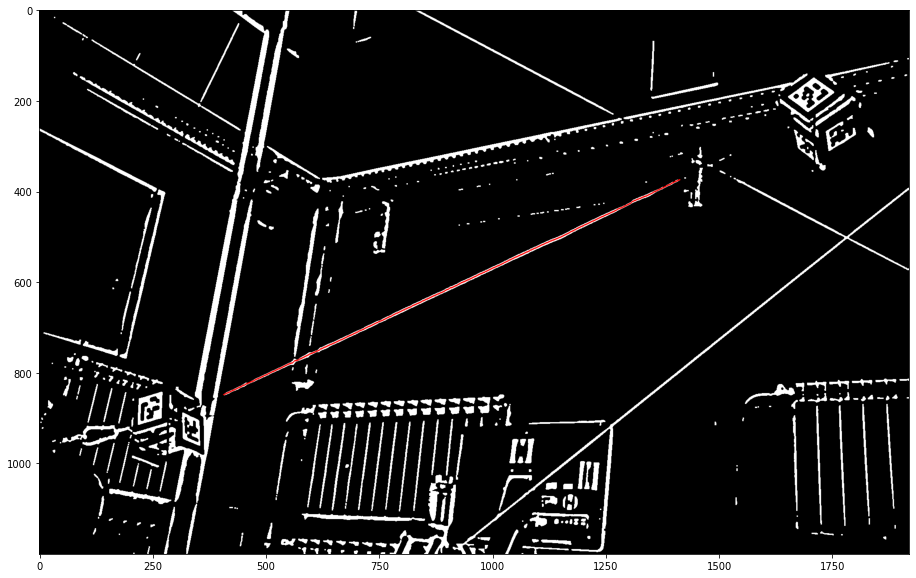

In [13]:
xs, ys = find_points(grayed, rays[0].get_middle())
found_lines = cv2.cvtColor(grayed.copy(), cv2.COLOR_GRAY2RGB)
for x, y in zip(xs, ys):
    cool = cv2.circle(found_lines, (x,y), 1, [255,0,0], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(found_lines)
plt.show()

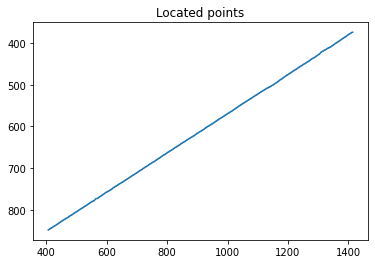

In [14]:
xs, ys = list(zip(*sorted(zip(xs,ys), key=lambda x: x[0])))
plt.plot(xs, ys)
plt.gca().invert_yaxis()
plt.title('Located points')
plt.show()

## Finding Catenary

Given points on the line we can try to predict the catenary

Epoch 0. Loss 12.136232376098633
Epoch 100000. Loss 0.12709598243236542
Epoch 200000. Loss 0.1066930741071701
Epoch 300000. Loss 0.09646890312433243
Epoch 400000. Loss 0.08963267505168915
Fitted arguments are a = 4.235037803649902, b = -0.2963928282260895, c = -1.4499197006225586


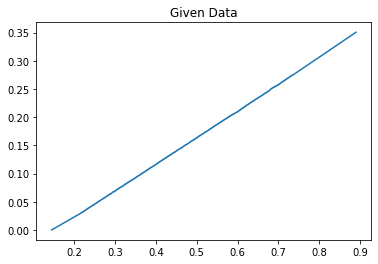

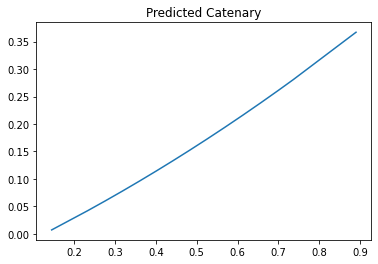

In [15]:
# Construct the ys and xs to be fit
# Consisting of lower and upper points of boxes
x, y = torch.Tensor([line_p1[0], *xs ,line_p2[0]])/1920, torch.Tensor([line_p1[1], *ys ,line_p2[1]])/1920
y = max(y) - y # Invert ys for better representation as in image
cat = CatenaryPredictor(x, y)
a, b, c, sample_ys =cat.solve(500000, 100000) # Fit the catenary

print(f'Fitted arguments are a = {a}, b = {b}, c = {c}')
plt.plot(x, y)
plt.title('Given Data')
plt.show()

plt.plot(list(x), list(sample_ys))
plt.title('Predicted Catenary')
plt.show()

In [16]:
# Calculating the sagging
# Difference between catenary and and perfect line
diff_cat = ((line_p1[1]-line_p2[1])/(2*1920) - lsq_catenary((x[-1]+x[0])/2, a, b, c))
# Difference between y's in 3D image
diff_met = (A[1] - B[1])
# Difference between pixels of 3D converted to 2D
diff_pixels = get_2d_from_3d(A, camparam.CameraMatrix)[1]-get_2d_from_3d(B, camparam.CameraMatrix)[1]

# meters/pixels*pixels = meters of sagging
sag_meters = diff_met/diff_pixels*diff_cat*1920

print("The sagging is ~{:.2f} mm".format(sag_meters*1000))

The sagging is ~10.73 mm


## Simulation

Follows the algorithm described in the report

In [17]:
# Initial values of a, x1 and x2
init_a = a.clone().detach()
init_x1 = x[0].clone().detach()
init_x2 = x[-1].clone().detach()

camera_matrix = torch.Tensor(camparam.CameraMatrix)

In [18]:
# Init simulation
sim = Simulation(init_a, init_x1, init_x2, camera_matrix)
a, x_1, x_2, new_u1, new_u2 = sim.simulate() # Get the values

print(f'Fitted: a={a.item()}, x_1 = {x_1.item()}, x_2 = {x_2.item()}')
print(f'Real values were: a={init_a.item()}, x_1 = {init_x1.item()}, x_2 = {init_x2.item()}')

print(f'Perfect u1 = {sim.perfect_u1.numpy()}, u2 = {sim.perfect_u2.numpy()}')
print(f'Ours u1 = {new_u1.detach().numpy()}, u2 = {new_u2.detach().numpy()}')

Epoch 0. Loss 64.20059204101562
Fitted: a=4.197910785675049, x_1 = 0.17245453596115112, x_2 = 0.9330259561538696
Real values were: a=4.235037803649902, x_1 = 0.14427083730697632, x_2 = 0.890625
Perfect u1 = [998.8575 680.4128], u2 = [1014.5937   687.03076]
Ours u1 = [998.8575  680.41315], u2 = [1014.8525  686.4888]
